# UMAP Plot

Use the bodies of text that describes a feed to create a UMAP Plot.

## Load Features

Load all information for all feeds or posts in the database that have features.

Store the results in the *feeds* or *posts* dicts.

In [1]:
import sqlite3
import umap, umap.plot
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import scipy

# stop words lists
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# stores the posts in a dict
feeds = dict()

print('Loading feed info...')

# connect to the db
conn = sqlite3.connect('feeds.db')
c = conn.cursor()
    
# select only the feeds for which the body of text 
# has already been generated
c.execute('SELECT url, text, title, description FROM feeds WHERE text IS NOT NULL AND title IS NOT NULL AND description IS NOT NULL;')
for entry in c.fetchall():
    feeds[entry[0]] = {
        'text': entry[1],
        'title': entry[2],
        'description': entry[3]
    }        

print('Loaded info for ' + str(len(feeds)) + ' feeds')

Loading feed info...
Loaded info for 37257 feeds


### Select Only First 500 Words From Feed Text

In [2]:
for feed_url in feeds:
    words = feeds[feed_url]['text'].split()
    words = words[:500]
    feeds[feed_url]['text'] = ' '.join(words)


In [2]:
lengths = [len(f['text'].split()) for f in feeds.values()]

print('Minimum length of text:', min(lengths))
print('Average length of text:', np.average(lengths))
print('Maximum length of text:', max(lengths))


Minimum length of text: 101
Average length of text: 463.4380921705988
Maximum length of text: 500


## Vectorize Documents

### Custom Pre-processor

Define custom pre-processor for the vectorizers.

In [3]:
from english_words import english_words_lower_set

# define a function that will be used to pre-process data before being vectorized
def custom_preprocessor(text):

    # convert to lower case
    text = text.lower()

    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # lemmatize text using WordNet
    lemmatizer = WordNetLemmatizer()

    lemmatized_words = list()
    for word in word_tokenize(text):

        # determine the part-of-speech tag for the word
        pos = nltk.pos_tag([word])[0][1][0] # only the first letter matters (hence the 0 at the end)

        # default to noun if the tag does not fall into the categories accepted by lemmatize()
        if pos != 'V' and pos != 'N' and pos != 'R' and pos != 'J':
            pos = 'N'
        if pos == 'J':
            pos = 'A'
        pos = pos.lower()

        # lemmatize the word and add to list
        lemma = lemmatizer.lemmatize(word, pos)
        if lemma in english_words_lower_set:
            lemmatized_words.append(lemma)

    # join the lemmatized words together
    text = ' '.join(lemmatized_words)   

    return text 

### Binary Matrix

Generate a doc-word matrix with binary counts for words.

In [4]:
corpus = list(f['text'] for f in feeds.values())

# generate a stop words list by joining multiple predefined lists
stopwords_list = list(set(sw_nltk) | set(sw_spacy) | set(STOPWORDS) | set(ENGLISH_STOP_WORDS))

# custom stop words (was given warning that these are not included in stop_words)
stopwords_list.extend(['doe', 'ha', 'le', 'need', 'sha', 'wa', 'wo', 'far', 'regard', 'use'])

vectorizer = CountVectorizer(max_features=20000, preprocessor=custom_preprocessor, binary=True, stop_words=stopwords_list)
doc_word = vectorizer.fit_transform(corpus)

# get the words (column labels)
words = vectorizer.get_feature_names()

# get the docs/feeds (keys of the feeds dict)
docs = list(feeds.keys())

print('Shape of doc-word matrix: ', str(doc_word.shape))
print('Number of documents (posts): ', str(len(docs)))
print('Number of words (features): ', str(len(words)))

# save the binary vectorized data
scipy.sparse.save_npz('binary_matrix', doc_word)
np.save('binary_words', np.asarray(words))

Shape of doc-word matrix:  (37257, 20000)
Number of documents (posts):  37257
Number of words (features):  20000


### TF-IDF Matrix

Generate a doc-word matrix with TF-IDF values for words.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer = TfidfVectorizer(max_features=20000, preprocessor=custom_preprocessor, stop_words=stopwords_list)
doc_word_tfidf = tfIdfVectorizer.fit_transform(corpus)

# get the words (column labels)
words_tfidf = tfIdfVectorizer.get_feature_names()

# save the binary vectorized data
scipy.sparse.save_npz('tfidf_matrix', doc_word_tfidf)
np.save('tfidf_words', np.asarray(words_tfidf))

### Load Matrices

Load the vectorized data from files.

In [2]:
# get the docs/feeds (keys of the feeds dict)
docs = list(feeds.keys())

# binary matrix
doc_word = scipy.sparse.load_npz('binary_matrix.npz')
words =  np.load('binary_words.npy')

# tfidf matrix
doc_word_tfidf = scipy.sparse.load_npz('tfidf_matrix.npz')
words_tfidf = np.load('tfidf_words.npy')

## CorEx Topic Modelling

Use the CorEx library to infer topics from the bodies of text of the feeds.

### Train the Model

In [19]:
# train the CorEx topic model
topic_model = ct.Corex(n_hidden=25, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words, docs=docs)

### Plot the Distribution of TCs For Each Topic

Use the plot to select an appropriate number of topics. Keep adding topics until additional ones do not significantly contribute to the overall TC.

Total Correlation of the model: 19.8335248476518


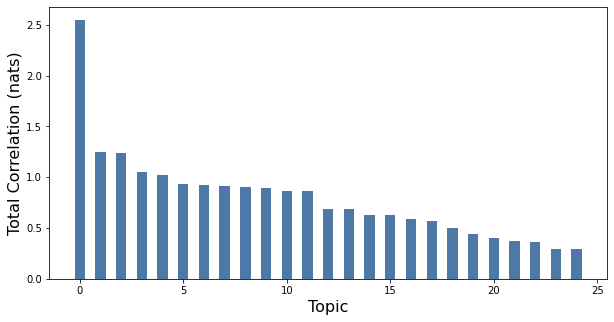

In [20]:
print('Total Correlation of the model:', str(topic_model.tc))

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

### Display All Topics Generated

In [21]:
topics = topic_model.get_topics(n_words=12)
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: recipe, delicious, ingredient, dish, chocolate, chicken, bake, sauce, sweet, creamy, cheese, dessert
1: law, court, god, church, legal, jesus, christian, police, federal, act, lawyer, attorney
2: health, patient, body, symptom, therapy, medicine, pain, mental, care, chronic, cancer, anxiety
3: travel, trip, park, visit, beach, island, tour, place, hotel, mountain, road, adventure
4: announce, easy, february, january, join, event, team, tuesday, president, award, director, debut
5: company, financial, market, investor, money, invest, finance, income, pay, tax, price, asset
6: post, appear, tip, league, man, john, sport, game, war, history, david, tournament
7: business, software, digital, platform, industry, tool, use, product, web, tech, content, automate
8: thing, like, want, think, know, feel, time, lot, way, people, try, life
9: love, beautiful, style, fashion, dress, gift, fun, gorgeous, valentine, photography, art, wear
10: city, south, country, west, north, town, coast, east, 

### Get the Topic and Top Feeds for Random Word

In [17]:
# Get the index of the word in the vocabulary
word_index = list(words).index('doctor')

# Get the topic associated with that word
word_topic = topic_model.clusters[word_index]

# Get top 10 documents for the topic
top_docs = topic_model.get_top_docs(topic=word_topic, n_docs=15, sort_by='log_prob')

print('Topic', word_topic)
for doc in top_docs:
    print(doc)

Topic 2
('https://www.brideeveryday.com/feed', 0.0)
('https://georgerook51.wordpress.com/feed/', 0.0)
('https://www.healthywomen.org/rss.xml?x=1', 0.0)
('https://www.soundhealthandlastingwealth.com/feed/', 0.0)
('https://www.healthista.com/feed/', 0.0)
('https://nutritionfacts.org/feed/', 0.0)
('https://www.mindfulnessfirst.org/blog?format=rss', 0.0)
('https://thesaffronstoryteller.com/feed/', 0.0)
('https://www.alittlenutrition.com/feed/', 0.0)
('https://thejointblog.com/feed/', 0.0)
('https://www.iawaketechnologies.com/feed/', 0.0)
('https://mysites.therapysites.com/0039423/blog/rss.xml', 0.0)
('https://howtherapyworks.com/feed/', 0.0)
('https://drgeraldstein.wordpress.com/feed/', 0.0)
('https://www.littlerockfamily.com/rss', 0.0)


### Reduce Using PCA

In [42]:
from sklearn.decomposition import PCA
import math

pca = PCA(n_components=3)
rgb = pca.fit_transform(topic_model.p_y_given_x)

rgb = rgb - np.min(rgb, axis=0)
rgb = rgb / np.max(rgb, axis=0)
rgb = rgb * 255

hex = []
for rgb_color in rgb:
    
    r = int(rgb_color[0])
    g = int(rgb_color[1])
    b = int(rgb_color[2])

    hex.append('#%02x%02x%02x' % (r, g, b))

### Assign a Topic to Each Feed

For each feed, assign it the topic such that the feed has the highest probability of belonging to that topic.

In [ ]:
# Make a hard assignment of one topic per document
hard_labels = np.zeros(doc_word.shape[0])

for i in range(hard_labels.shape[0]):
    hard_labels[i] = np.argmax(topic_model.p_y_given_x[i])

## UMAP Plots

### Topic Probabilities

Create an interactive UMAP plot based on the probabilities that each feed belongs to a topic. 

In [ ]:
# fit UMAP model
mapper = umap.UMAP().fit(topic_model.p_y_given_x)

In [ ]:
# data to be displayed when hovering over a point in the interactive plot
hover_data = pd.DataFrame({
    'title': [f['title'] for f in list(feeds.values())],
    'description': [f['description'] for f in list(feeds.values())],
    'label': hard_labels
})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=hard_labels, hover_data=hover_data, point_size=4)
umap.plot.show(p)

### TF-IDF

Use TF-IDF values without topic modelling in the UMAP plot.

In [43]:
# fit umap with tf-idf doc word matrix (without topic modelling)
tfidf_raw_mapper = umap.UMAP().fit(doc_word_tfidf)

In [46]:
hover_data = pd.DataFrame({
    'title': [f['title'] for f in feeds.values()],
    'description': [f['description'] for f in feeds.values()],
})

labels = [f['title'] for f in feeds.values()]

umap.plot.output_notebook()
p = umap.plot.interactive(tfidf_raw_mapper, labels=labels, color_key=hex, hover_data=hover_data, point_size=4)
umap.plot.show(p)

Loading BokehJS ...